# Spray Cost Benefit Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
import geopandas as gpd
from shapely.geometry import Point,polygon

plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
train = pd.read_csv('./assets/train_cleaned.csv')
spray = pd.read_csv('./assets/spray.csv')

# EDA of Spray Data

In [3]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [4]:
#Drop duplicates in spray
spray = spray[spray.duplicated(subset=['Date','Latitude','Longitude'])==False]

In [5]:
#Converting Lat & Long in spray to float
spray['Latitude'] =spray['Latitude'].astype('float64')
spray['Longitude'] =spray['Longitude'].astype('float64')

In [6]:
#Initiating GeoDataFrame and adding Geometry column to train DataFrame
crs = {'init': 'epsg:3395'}
geometry = [Point(xy) for xy in zip(train['Longitude'],train['Latitude'])]
geo_df = gpd.GeoDataFrame(train,crs=crs,geometry=geometry)

In [7]:
#Show all dates of spray
spray['Date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2013-07-25    1607
2013-08-22    1587
2011-09-07    1573
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

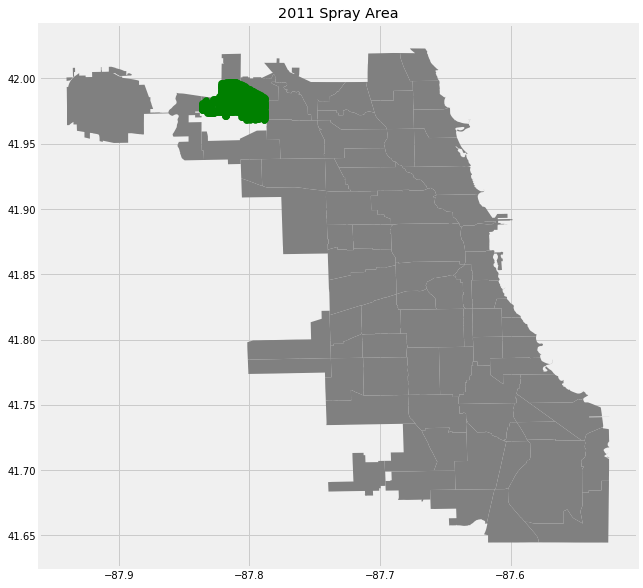

In [8]:
#Create geometry dataframe from spray with data only from 2011
#Remove outlier at Latitude < 42.1
s = spray[spray['Latitude'] < 42.1][(spray[spray['Latitude'] < 42.1]['Date']> '2011-01-01') & (spray[spray['Latitude'] < 42.1]['Date']< '2012-01-01')]
geometry1 = [Point(xy) for xy in zip(s['Longitude'],s['Latitude'])]
geo_df1 = gpd.GeoDataFrame(s,crs=crs,geometry=geometry1)
    
#Plot street map with shape and mark spray area with green
street_map = gpd.read_file('./shapes/geo_export_9cbabb95-c061-4672-861f-5d4da978e3c3.shp')
fig,ax = plt.subplots(figsize=(15,10))
street_map.plot(ax=ax,color='grey')
geo_df1.plot(ax=ax,color='green')

ax.set_title('2011 Spray Area')
plt.savefig('./graphs/2011_spray_area.png',bbox_inches='tight')

plt.show()

Spray data in 2011 are very limited (2 dates to be exact), hence we will only plot and analyse the spray effect base on 2013 data.

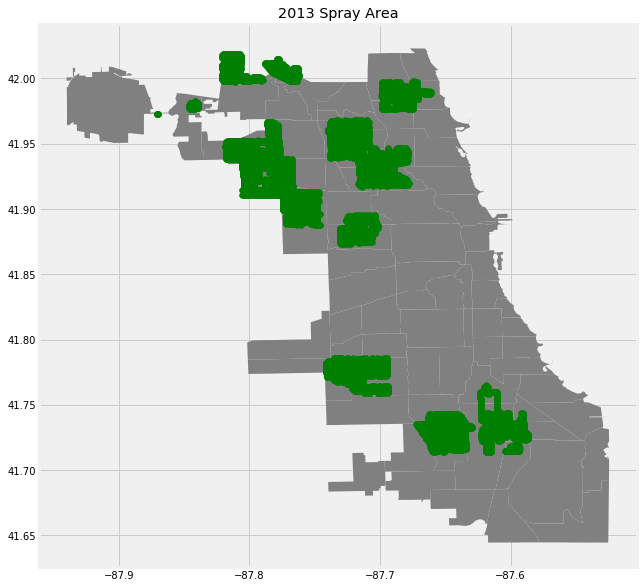

In [9]:
#Create geometry dataframe from spray with data only from 2013
#Remove outlier at Latitude < 42.1
s = spray[spray['Latitude'] < 42.1][(spray[spray['Latitude'] < 42.1]['Date']> '2013-01-01') & (spray[spray['Latitude'] < 42.1]['Date']< '2014-01-01')]
geometry1 = [Point(xy) for xy in zip(s['Longitude'],s['Latitude'])]
geo_df1 = gpd.GeoDataFrame(s,crs=crs,geometry=geometry1)
    
#Plot street map with shape and mark spray area with green
street_map = gpd.read_file('./shapes/geo_export_9cbabb95-c061-4672-861f-5d4da978e3c3.shp')
fig,ax = plt.subplots(figsize=(15,10))
street_map.plot(ax=ax,color='grey')
geo_df1.plot(ax=ax,color='green')

ax.set_title('2013 Spray Area')
plt.savefig('./graphs/2013_spray_area.png',bbox_inches='tight')

plt.show()

Spray data in 2013 spread from July to September in 2013.

In [10]:
#Display all spray dates in 2013
spray[spray['Date']>'2013-01-01']['Date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
Name: Date, dtype: int64

In [11]:
#Convert Date column in both geo_df and spray to datetime
geo_df['Date'] = pd.to_datetime(geo_df.Date)
spray['Date']= pd.to_datetime(spray.Date)

# Plotting Area of Spray & Trap Location

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


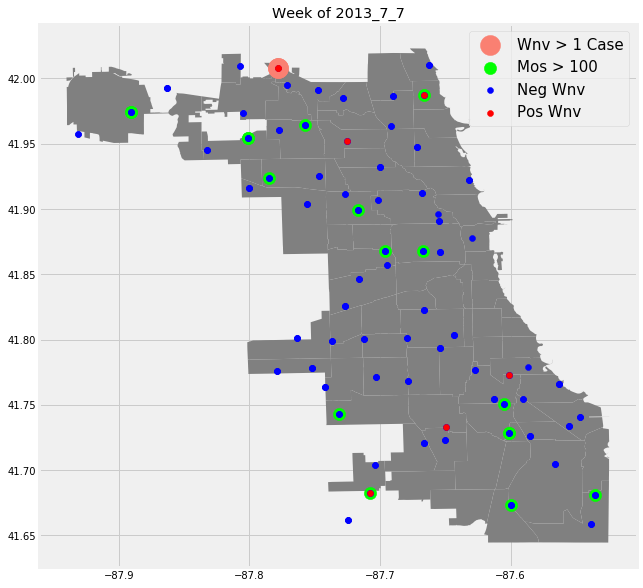

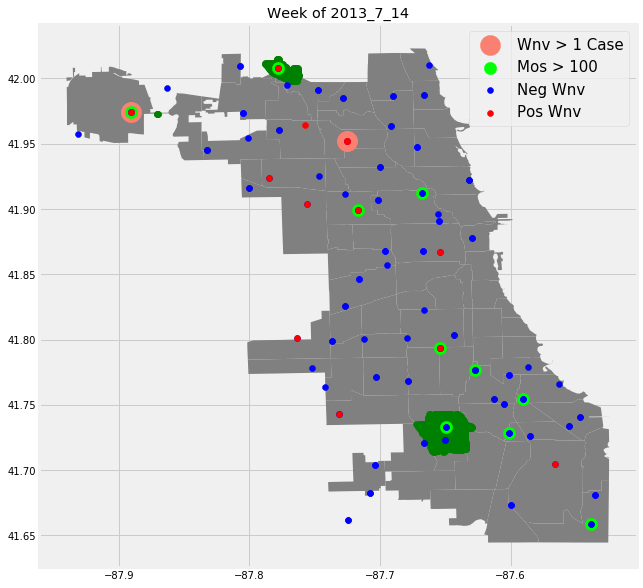

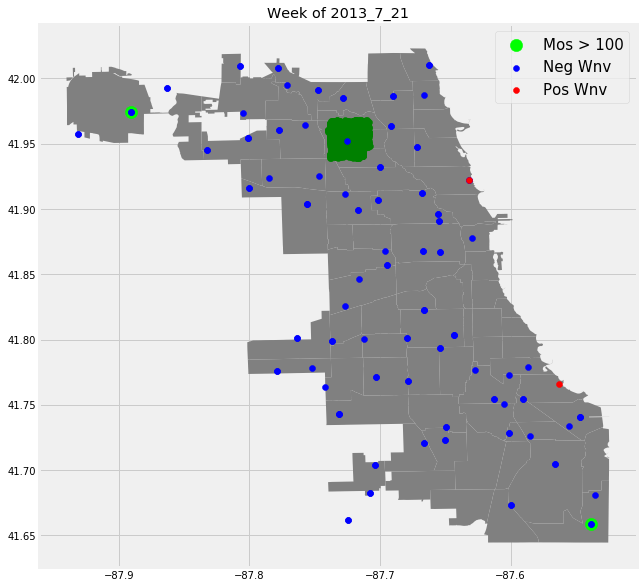

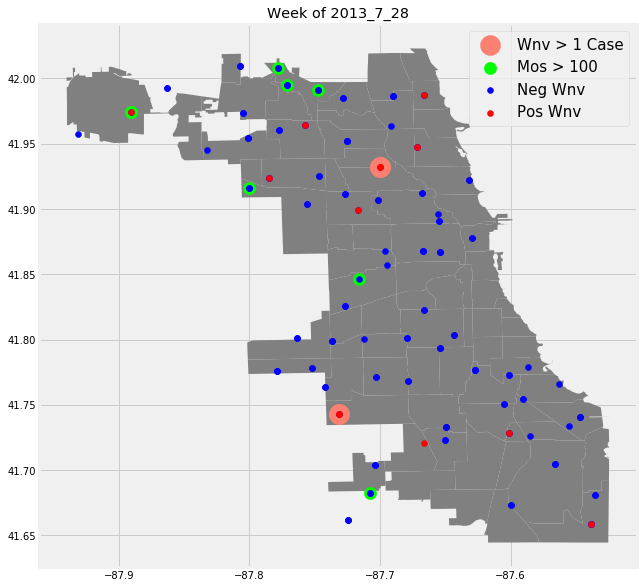

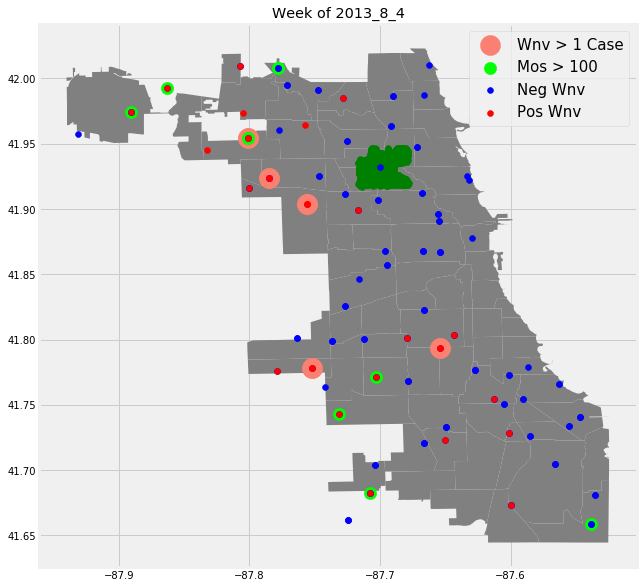

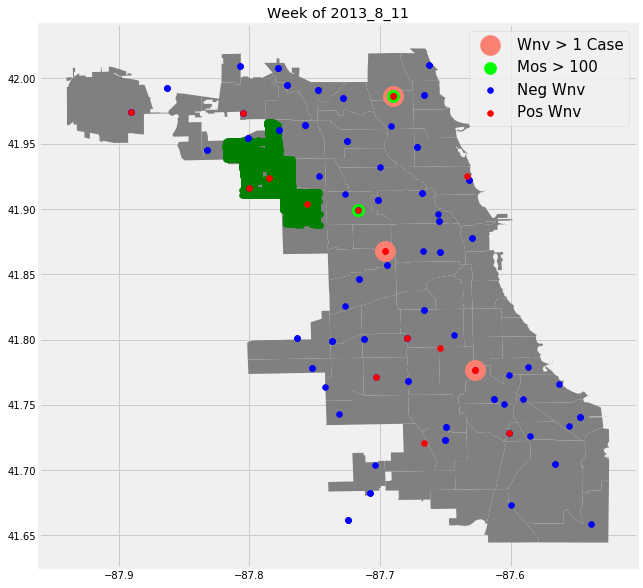

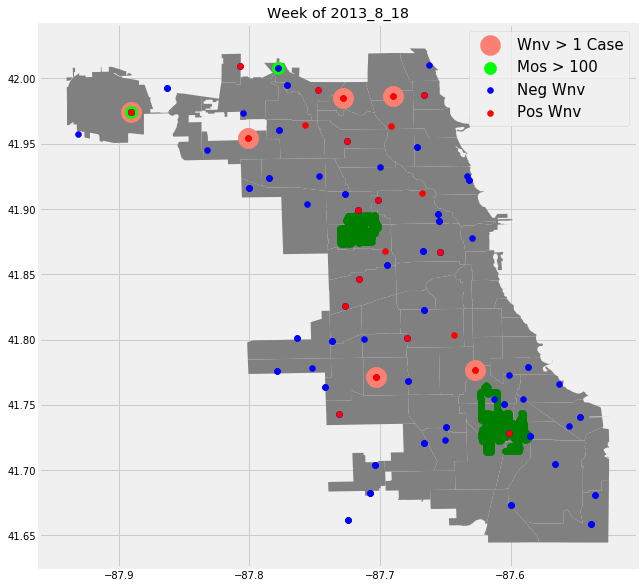

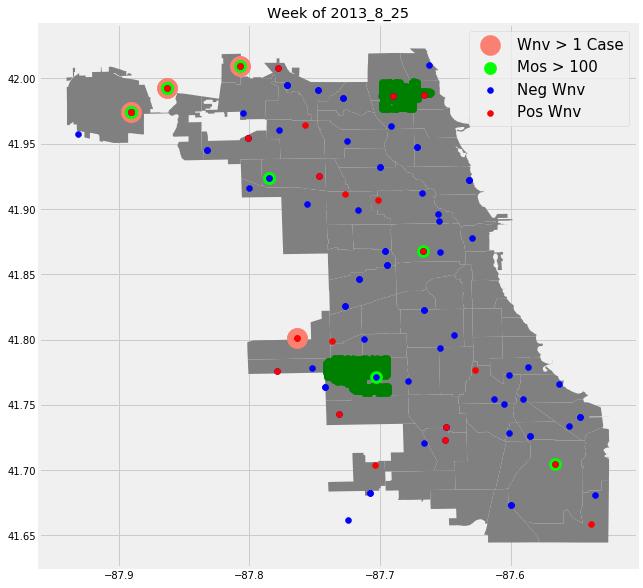

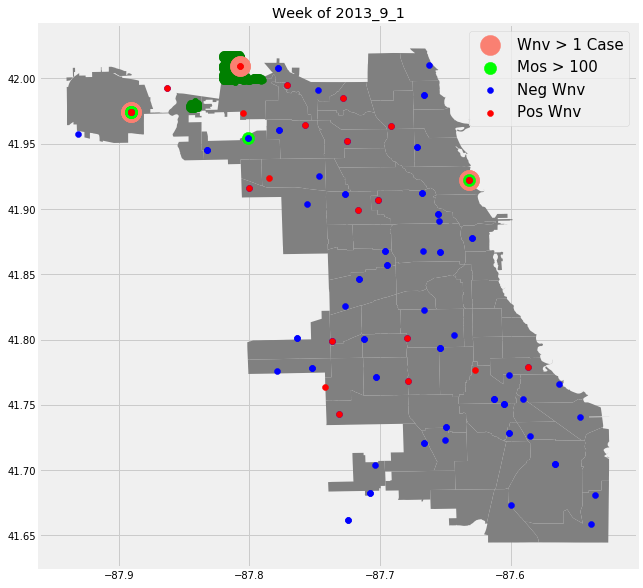

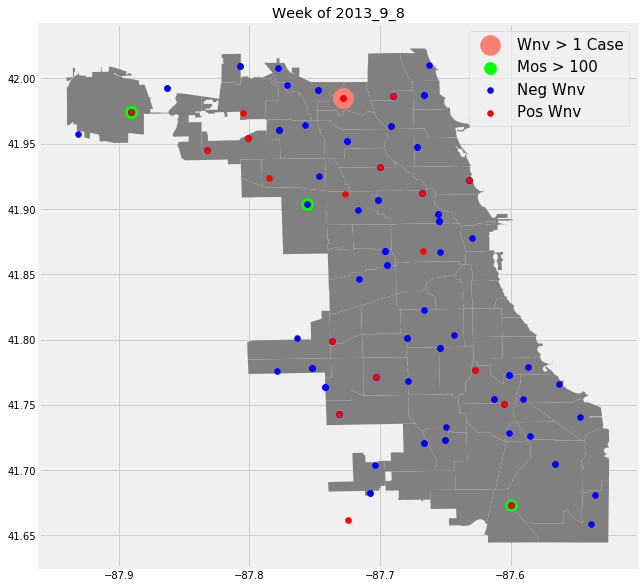

In [12]:
#Initialising constant
mos_filcount = 50
wnv_filcount = 1

#Create dataframe with Total Mosquito Count > 50 and with Species 'PIPIENS' & 'PIPIENS/RESTUANS' present
geo_df3 = geo_df[geo_df['Tot_Mos_Species']>mos_filcount][(geo_df[geo_df['Tot_Mos_Species']>mos_filcount]['Species']=='PIPIENS/RESTUANS') | (geo_df[geo_df['Tot_Mos_Species']>mos_filcount]['Species']=='PIPIENS')]

#Initialising start date for loop later
date1 = pd.to_datetime('2013-06-30')
date2 = pd.to_datetime('2013-07-7')
#Number of days to add for each loop
offset = timedelta(days=7)
#Number of weeks of graph to plot
weeks = 10

#Create loop to plot graph
for i in range(weeks):
    
    #plot graph based on weekly data
    date1 = date1 + offset 
    date2 = date2 + offset
    
    #Count number of Wnv Present case in each trap using groupby, and create new column by merging into original dataframe on trap number
    geo_count = geo_df[geo_df['WnvPresent']==1][(geo_df[geo_df['WnvPresent']==1]['Date']> date1) & (geo_df[geo_df['WnvPresent']==1]['Date']< date2)].groupby(['Trap'])['geometry'].count()
    #Merge
    geo = pd.merge(geo_df[geo_df['WnvPresent']==1][(geo_df[geo_df['WnvPresent']==1]['Date']> date1) & (geo_df[geo_df['WnvPresent']==1]['Date']< date2)],geo_count,on='Trap',how='right')
    #Rename column name
    geo.columns = ['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Month', 'Year', 'Weekday',
       'Tot_Mos_Species', 'geometry', 'Num_Cases']
    #Create dataframe with only no. of Wnv Case > 1 in each trap
    geo_df2 = geo[geo['Num_Cases']>wnv_filcount]
    
    #Create geometry dataframe from spray with data only from within date1 and date2
    #Remove outlier at Latitude < 42.1
    s = spray[spray['Latitude'] < 42.1][(spray[spray['Latitude'] < 42.1]['Date']> date1) & (spray[spray['Latitude'] < 42.1]['Date']< date2)]
    geometry1 = [Point(xy) for xy in zip(s['Longitude'],s['Latitude'])]
    geo_df1 = gpd.GeoDataFrame(s,crs=crs,geometry=geometry1)
    
    #Plot street map with shape and mark spray area with green
    street_map = gpd.read_file('./shapes/geo_export_9cbabb95-c061-4672-861f-5d4da978e3c3.shp')
    fig,ax = plt.subplots(figsize=(15,10))
    street_map.plot(ax=ax,color='grey')
    geo_df1.plot(ax=ax,color='green')


    #Wnv Present Case > 1
    geo_df2[(geo_df2['Date']> date1) & (geo_df2['Date']< date2)].plot(ax=ax,color='salmon',label='Wnv > 1 Case',markersize=400)
    #Mosquito > 100
    geo_df3[(geo_df3['Date']> date1) & (geo_df3['Date']< date2)].plot(ax=ax,color='lime',label='Mos > 100',markersize=150)
    #Wnv Not present
    geo_df[geo_df['WnvPresent']==0][(geo_df[geo_df['WnvPresent']==0]['Date']> date1) & (geo_df[geo_df['WnvPresent']==0]['Date']< date2)].plot(ax=ax,color='blue',label='Neg Wnv')
    #Wnv Present
    geo_df[geo_df['WnvPresent']==1][(geo_df[geo_df['WnvPresent']==1]['Date']> date1) & (geo_df[geo_df['WnvPresent']==1]['Date']< date2)].plot(ax=ax,color='red',label='Pos Wnv')
    
    #Making the date of the start of the week into string
    string = str(date1.year) + '_' + str(date1.month)+ '_'  + str(date1.day)
    #Set title
    ax.set_title('Week of '+ string)
    #Set legend
    ax.legend(fontsize=15)
    #Saving graph
    plt.savefig('./graphs/' + string  + '.png',bbox_inches='tight')


Based on the 10 weeks geo plot of spray area and Wnv present case in mosquito traps, it seems that the spray areas are mostly determined by the previous week's data of area where Traps contain Wnv positive mosquitos. However, not all Trap areas with Wnv positive case were being sprayed; hence, the exact spray strategy in 2013 is unknown and can be further improved. 

Nevertheless, it is clear from the 10 weeks plot above that the spraying worked in areas with Wnv positive; as mosquitos in the same area with Wnv positive disappear in the following week after spraying.

In [13]:
print('Total Mosquitos with Wnv Positive in 2011: {}'.format(geo_df[(geo_df['Date']>'2011-01-01') & (geo_df['Date']<'2012-01-01')]['WnvPresent'].sum()))
print('Total Mosquitos with Wnv Positive in 2013: {}'.format(geo_df[(geo_df['Date']>'2013-01-01') & (geo_df['Date']<'2014-01-01')]['WnvPresent'].sum()))

Total Mosquitos with Wnv Positive in 2011: 50
Total Mosquitos with Wnv Positive in 2013: 199


In [14]:
print('Total Spray count in 2011: {}'.format(spray[(spray['Date']>'2011-01-01') & (spray['Date']<'2012-01-01')]['Date'].count()))
print('Total Spray count in 2013: {}'.format(spray[spray['Date']>'2013-01-01']['Date'].count()))

Total Spray count in 2011: 1668
Total Spray count in 2013: 12626


| Year                      | Total Spray Count  | Total Mosquitos with Wnv \+Ve | No\. of Wnv Human case* |Ratio of Wnv Mos:Human|
|---------------------------|-------------------------------|-------------------|------------------------|----------------------|
| 2011                      | 1668                           |50               | 8                      |6.25                  |
| 2013                      | 12626                          | 199             | 37                     |5.38                  |
| Differences \(2013/2011\) | 7\.57                         | 3\.98             | 4\.63                  |0.86                      |


By doing a simple math from the above table, we can see that even though the spraying effort in 2013 increases by 7.57 times compared to 2011, the ratio of Wnv Mos:Human did not decrease by 7.57 (but by 1.16 instead).

This means that the spraying strategy has lots of room for improvement.

*[Chicago West Nile Virus 2019 data brief](https://www.chicago.gov/content/dam/city/depts/cdph/food_env/general/West_Nile_Virus/WNV_2018databrief_FINALJan102019.pdf)

By visually inspect the number of traps which the spraying in 2013 were conducted because of Wnv positive case (Total: 14), we can calculate the average no. of spray per Wnv postive trap.

Assume each spray cost USD 100 ([Source]('https://www.homeadvisor.com/cost/environmental-safety/mosquito-control/'))

In [48]:
#Average no. of spray/infected trap in 2013
avg_spray = spray[spray['Date']>'2013-01-01']['Date'].count()/14
#Average Price
avg_price = 100
avg_spray

901.8571428571429

In [50]:
print('Estimated spending in Spraying in 2013: ${}'.format(round(spray[spray['Date']>'2013-01-01']['Date'].count()*avg_price)))

Estimated spending in Spraying in 2013: $1262600


We will then estimate the spraying cost of each option below, assuming the scenario of employing the strategy in each option in 2013. 

## Suggestions On Spray Strategy For Upcoming Mosquito Season

Based on our prediction model using Random Forest Classifier, the Chicago government can plan the spray strategy for the upcoming mosquito season on a weekly basis. 

For example, using the weather data and mosquito count of PIPIENS/RESTUANS this week to predict Wnv positive trap area for the following week. 

### Option 1

Using the prediction, spray can be conducted in all areas predicted to have at least 1 Wnv positive mosquito.

|      |   |
|------|---|
| **Pros** | Wnv positive mosquito can be dramatically reduced, thereby reducing Wnv human case  |
| **Cons** | Spraying all positive Wnv areas can be very costly   |



In [45]:
#Find all Wnv Positive case in 2013
positive = geo_df[geo_df['WnvPresent']==1][(geo_df[geo_df['WnvPresent']==1]['Date']> '2013-01-01') & (geo_df[geo_df['WnvPresent']==1]['Date']< '2014-01-01')]
len(positive)

199

In [46]:
print('Total Spending for option 1: ${}'.format(round(len(positive)*avg_spray*avg_price,2)))

Total Spending for option 1: $17946957.14


### Option 2

Using the prediciton model and the community areas as currently being used by Chicago, spray can be conducted when at least 2 traps in the same community are predicted to have Wnv positive in the following week.

![Chicago Areas](.\graphs\2013_8_4.png)



|      |   |
|------|---|
| **Pros** | Reduce Wnv positive mosquitos in area of high risk while saving cost of spraying  |
| **Cons** | Singular traps with only 1 Wnv positive mosquito will be missed out despite potential risk|

For example, 9 traps should be sprayed in the plot above. In 10 week, there are a total 41 traps in the same community with more than 1 positive cases.

In [51]:
print('Total Spending for option 2: ${}'.format(round(41*avg_spray*avg_price,2)))

Total Spending for option 2: $3697614.29


### Option 3

In [52]:
# Get the top 2 latitude and longitude coordinates with wnvpresent area
wnvpresent_lat_index=[]
wnvpresent_lon_index=[]
for i in range(2):
    wnvpresent_lat_index.append(train[train['WnvPresent'] == 1].groupby('Latitude')['Longitude'].value_counts().sort_values(ascending=False).head().index[i][0])
    wnvpresent_lon_index.append(train[train['WnvPresent'] == 1].groupby('Latitude')['Longitude'].value_counts().sort_values(ascending=False).head().index[i][1])

In [53]:
wnvpresent_lat_lon = [(lat,lon) for lat,lon in zip(wnvpresent_lat_index,wnvpresent_lon_index)]
wnvpresent_lat_lon = pd.DataFrame(wnvpresent_lat_lon,columns=['Lat','Long'])
wnvpresent_lat_lon

,Lat,Long
0,41.974689,-87.890615
1,41.673408,-87.599862


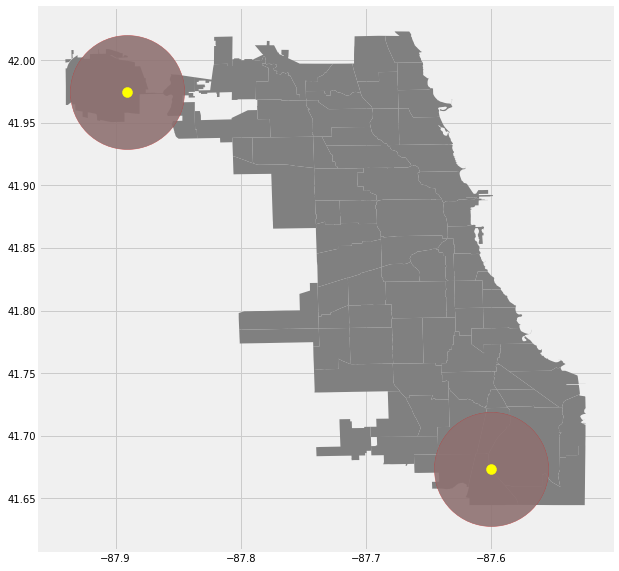

In [54]:
geometry1 = [Point(xy) for xy in zip(wnvpresent_lat_lon['Long'],wnvpresent_lat_lon['Lat'])]
wnvpresent_lat_lon = gpd.GeoDataFrame(wnvpresent_lat_lon,crs=crs,geometry=geometry1)

street_map = gpd.read_file('./shapes/geo_export_9cbabb95-c061-4672-861f-5d4da978e3c3.shp')
fig,ax = plt.subplots(figsize=(15,10))
street_map.plot(ax=ax,color='grey')
wnvpresent_lat_lon.plot(ax=ax,color='red',markersize=13000,alpha=0.5)
wnvpresent_lat_lon.plot(ax=ax,color='grey',markersize=12900,alpha=0.8)
wnvpresent_lat_lon.plot(ax=ax,color='yellow',markersize=100)

plt.savefig('./graphs/3_key_points.png',bbox_inches='tight')
plt.show()

2 of the top importance features in the random forest classification model uses Dist_0, Dist_1 to predict the presence of Wnv positive trap. These 2 features are the distances from point 0 and point 1, which are the top 2 points with the most Wnv positive trap in the train datasets. Hence, it means that the closer the traps are to these 2 point, the higher the probability of

Therefore, the spraying plan can be conducted within 5km radius of these 2 points to contain the most high risk Wnv positive Mosquitos from spreading to the rest of Chicago.

|      |   |
|------|---|
| **Pros** | Cost-effective method that only target high risk Wnv positive area based on train datasets  |
| **Cons** | Assume that most Wnv positive mosquitos came from these 2 areas while missing out other areas|

In [55]:
#Finding all Wnv positive trap in 2013 with distance less than 5km away from Dist_0 & Dist_1
len(positive[positive['geometry'].distance(geometry1[0])<0.05]) + len(positive[positive['geometry'].distance(geometry1[1])<0.05])

23

In [56]:
print('Total Spending for option 3: ${}'.format(round(23*avg_spray*avg_price,2)))

Total Spending for option 3: $2074271.43


## Option 4

Release genetically modified mosquitos that prevent mosquito eggs from hatching after mating with existing mosquito. This eliminate the need for long term spraying plan, providing a long term solution with an one time R&D investment cost. Further information of such method can be obtained by contacting the National Environmental Agency of Singapore, which spent SGD 5 million (USD $ 3.6 million) to build a mosquito breeding facility in 2019. [Source](https://www.channelnewsasia.com/news/singapore/wolbachia-mosquitoes-new-facility-aedes-aegypti-dengue-12145012)

|      |   |
|------|---|
| **Pros** |Long term solution that can address future moquito problems, which are bound to worsen due to global warming  |
| **Cons** |Require a significant R&D investment cost & time to implement|

## Summary

|        | Option 1                                                                           | Option 2                                                                                   | Option 3                                                                                      | Option 4                                                                                                     |
|--------|------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------|
| **Method** | Spray all Wnv Positive Areas                                                       | Spray based on community areas                                                             | Spray based on distance from 2 key points                                                    | Release genetically modified mosquitos                                                                       |
| **Pros**   | Wnv positive mosquito can be dramatically reduced, thereby reducing Wnv human case | Reduce Wnv positive mosquitos in area of high risk while saving cost of spraying           | Cost\-effective method that only target high risk Wnv positive area based on train datasets   | Long term solution that can address future mosquito problems, which are bound to worsen due to global warming |
| **Cons**   | Spraying all positive Wnv areas can be very costly                                 | Singular traps with only 1 Wnv positive mosquito will be missed out despite potential risk | Assume that most Wnv positive mosquitos came from these 2 areas while missing out other areas | Require a significant R&D investment cost & time to implement                                                |
| **Cost** | \$17,946,957 | \$$3,697,614 | \$2,074,271 |  \$3,599,880|


Based all the 10 weeks plot of spraying & Wnv positive trap of Chicago in 2013, we can conclude that spraying does have a positive effect on controlling Wnv human cases. However, as the spray strategy seems to be based on current week's trap data, the spraying areas are always lag by 1 week and made the spraying effort sometimes useless. 

Our random forest classification model is able to predict the presence of Wnv positive in each mosquito trap, with an accuracy of (score). Using the classification model, we can predict next week's Wnv presence based on this week's data and plan the spraying strategy with the 4 options given above. 

More information would be required to make the model more accurate at predicting, such as 

1) Number of mosquito in test dataset

2) Number of Wnv human cases and area of infection

3) More spray area data other than 2011 and 2013

Nevertheless, we conclude that our random forest classificaion model has performed up to expectation in predicting Wnv presence in Chicago. 